# Prototype Selection for Nearest Neighbors

In [5]:
# Importing all the necessary libraries

import numpy as np
from mlxtend.data import loadlocal_mnist
import matplotlib.pyplot as plt
from sklearn.neighbors import BallTree

import ipywidgets as widgets
from IPython.display import display
from ipywidgets import interact, interactive, fixed, interact_manual
import pandas as pd

In [2]:
# Loading all the MNIST training and testing data

training_images_file = 'train-images.idx3-ubyte'
training_labels_file = 'train-labels.idx1-ubyte'
test_images_file = 't10k-images.idx3-ubyte'
test_labels_file = 't10k-labels.idx1-ubyte'

### Loading data
MNIST datasets have been loaded

In [3]:
x_train_images, y_train_labels = loadlocal_mnist( training_images_file, training_labels_file)
x_test_images, y_test_labels = loadlocal_mnist(test_images_file, test_labels_file)

In [4]:
# Dimensions of all training and testing images and labels

print('Dimension of training images:', np.shape(x_train_images))
print('Dimension of trainig labels:',np.shape(y_train_labels))
print('Dimension of testing images:', np.shape(x_test_images))
print('Dimension of testing labels:',np.shape(y_test_labels))

Dimension of training images: (60000, 784)
Dimension of trainig labels: (60000,)
Dimension of testing images: (10000, 784)
Dimension of testing labels: (10000,)


In [7]:
# KNN Classification with accuracy
def KNN_classifier(x_train, y_train, x_test, y_test, k=1):
    from sklearn.neighbors import KNeighborsClassifier
    from sklearn import metrics

    x_train = np.array(x_train).reshape(len(x_train), -1)
    x_test = np.array(x_test).reshape(len(x_test), -1)
    
    res = KNeighborsClassifier(n_neighbors=k)
    res.fit(x_train, y_train)
    
    y_pred = res.predict(x_test)

    test_acc = metrics.accuracy_score(y_test, y_pred)
    return test_acc

In [8]:
# KNN Classifier with accuracy for the complete dataset

KNN_classifier(x_train_images, y_train_labels, x_test_images, y_test_labels, k=1)

0.9691

In [27]:
# NEW PROTOTYPE SELECTION Function

def new_prototypes(M):
    labels = []
    for i in range(10):
        labels.append(x_train_images[y_train_labels == i])
    
    from sklearn.cluster import KMeans

    kmeans_res = []
    samples = []

    for i in range(10):
        kmeans_res.append(KMeans(n_clusters=int(M/10), init='k-means++',random_state=0).fit(labels[i]))
        samples.append(kmeans_res[i].cluster_centers_)

    proto_sample = np.concatenate((samples[0], samples[1],
                               samples[2], samples[3],
                               samples[4], samples[5],
                               samples[6], samples[7],
                               samples[8], samples[9]
                              ), axis = 0
                              )
    
    sample_labels = []
    for i in range(10):
        sample_labels.append(np.full((int(M/10),), i))
    
    proto_labels = np.concatenate((sample_labels[0], sample_labels[1],
                               sample_labels[2], sample_labels[3],
                               sample_labels[4], sample_labels[5],
                               sample_labels[6], sample_labels[7],
                               sample_labels[8], sample_labels[9],
                              ), axis = 0
                              )
    
    return proto_sample, proto_labels

In [28]:
# Random Prototype

def random_prototypes(M):
    indices = np.random.choice( len(y_train_labels) , M, replace=False)
    return x_train_images[indices,:], y_train_labels[indices] 

In [9]:
# example_images, example_labels = random_prototypes(1000)
# print("Shape of train_data:", x_train_images.shape)
# print("Shape of array of prototypes: ", example_images.shape)

Shape of train_data: (60000, 784)
Shape of array of prototypes:  (1000, 784)


In [9]:
# Calculate KNN Error
def KNN_error(prototype_data, prototype_labels):
    ball_tree = BallTree(prototype_data, metric='euclidean')
    test_neighbors = np.squeeze(ball_tree.query(x_test_images, k=1, return_distance=False))
    test_fit = prototype_labels[test_neighbors]
    return sum(test_fit != y_test_labels)/float(len(test_fit))

In [10]:
# Calculate Mean Error
def mean_error(prototype_func, M, k=1):
    errors = np.zeros(k)
    for i in range(0,k):
        prototype_data, prototype_labels = prototype_func(M)
        errors[i] = KNN_error(prototype_data, prototype_labels) 
    return np.mean(errors), np.std(errors)/np.sqrt(k)

In [12]:
# Running the random selection data for 1NN on different M values

M_values = [1000, 2000, 3000, 5000, 10000]
randomp_errors = np.zeros(5)
randomp_errorbars = np.zeros(5)
for i in range(0, len(randomp_errors)):
    randomp_errors[i], randomp_errorbars[i] = mean_error(random_prototypes, M_values[i], k=1)

In [14]:
# Running the new prototype data for 1NN on different M values

newp_errors = np.zeros(5)
newp_errorbars = np.zeros(5)
for i in range(0, len(newp_errors)):
    newp_errors[i], newp_errorbars[i] = mean_error(new_prototypes, M_values[i], k=1)

In [35]:
# Random Selection Errors for the following values of M:
# M = 100, 1000, 2000, 5000, 10000
print(randomp_errors)
print('Mean Accuracy: ' + str(np.average(1 - randomp_errors)))
print('Standard Deviation: ' + str(np.std(randomp_errors)))

[0.1138 0.0916 0.0781 0.062  0.0504]
Mean Accuracy: 0.92082
Standard Deviation: 0.022259415985151094


In [34]:
# New Prototype Errors for the following values of M:
# M = 1000, 2000, 3000, 5000, 10000
print(newp_errors)
print('Mean Accuracy: ' + str(np.average(1 - newp_errors)))
print('Standard Deviation: ' + str(np.std(newp_errors)))

[0.043  0.0369 0.0352 0.0331 0.0307]
Mean Accuracy: 0.9642199999999999
Standard Deviation: 0.004164324675142416


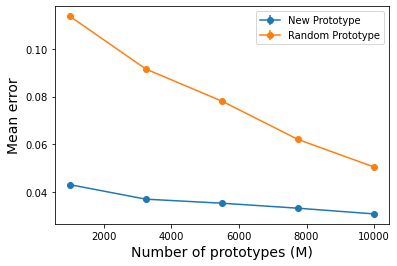

In [41]:
# Plot of the errors in both the methods

plt.errorbar(np.linspace(1000, 10000, 5), newp_errors, yerr=newp_errorbars*2.0, fmt='-o', label = 'New Prototype')
plt.errorbar(np.linspace(1000, 10000, 5), randomp_errors, yerr=randomp_errorbars*2.0, fmt='-o', label = 'Random Prototype')

plt.xlabel('Number of prototypes (M)', fontsize=14)
plt.ylabel('Mean error', fontsize=14)
plt.legend(loc = 'upper right')
plt.show()

In [56]:
# Confidence Intervals
import math
for i in range(0, len(M_values)):
        mean_accuracy = np.average(1 - newp_errors[i])
        interval = 1.96 * math.sqrt( (mean_accuracy * (1 - mean_accuracy)) / M_values[i])
        print('%.3f' % interval, M_values[i], newp_errors[i])

0.013 1000 0.043
0.008 2000 0.0369
0.007 3000 0.0352
0.005 5000 0.0331
0.003 10000 0.0307


In [18]:
@interact_manual(M=(1000,10000,1000), rounds=(1,10))
def comparison(M, rounds):
    print("Comparing your prototype selection method to random prototype selection...")
    rand_err, rand_std = mean_error(random_prototypes, M, rounds) 
    new_err, new_std = mean_error(new_prototypes, M, rounds) 
    
    print;print("Number of prototypes:", M)
    print("Number of trials:", rounds)
    print("Error for random prototypes:", rand_err )
    print("Error for your prototypes:", new_err );print
    if rand_err < new_err:
        print("RANDOM prototypes win!")
    else:
        print("The new prototypes win!")

interactive(children=(IntSlider(value=5000, description='M', max=10000, min=1000, step=1000), IntSlider(value=…